##### config.py

In [2]:
from dataclasses import dataclass

@dataclass
class RNAConfig:
    """Global configuration for the RNAcompete Data Pipeline."""
    
    # Data Path
    DATA_PATH: str = "norm_data.txt" #NOTE: Only change this if you want to use a different path
    
    # Metadata is an Excel file
    METADATA_PATH: str = "metadata.xlsx" #NOTE: Only change this if you want to use a different path
    METADATA_SHEET: str = "Master List--Plasmid Info"
    
    # Save Path
    SAVE_DIR: str = "/home/catarinabarata/dl/data" #NOTE: Only change this if you want to use a different path
    
    # Sequence Parameters
    SEQ_MAX_LEN: int = 41
    ALPHABET: str = "ACGUN"
    
    # Preprocessing
    CLIP_PERCENTILE: float = 99.95
    EPSILON: float = 1e-6  # For numerical stability
    
    # Split Identifiers
    TRAIN_SPLIT_ID: str = "SetA"
    TEST_SPLIT_ID: str = "SetB"
    
    VAL_SPLIT_PCT: float = 0.2
    SEED: int = 42 # NOTE: Change this only if you want to test reproducibility

#### utils.py

In [3]:
import os
import random
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from typing import List, Tuple



def configure_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


class RNACompeteLoader:
    def __init__(self, config: RNAConfig):
        """
        Initializes the loader.
        """
        self.cfg = config
        self.meta_df = None
        self.data_df = None
        self.protein_to_id = None

        # Setup Encoding
        self.char_map = {
            'A': np.array([1, 0, 0, 0], dtype=np.float32),
            'C': np.array([0, 1, 0, 0], dtype=np.float32),
            'G': np.array([0, 0, 1, 0], dtype=np.float32),
            'U': np.array([0, 0, 0, 1], dtype=np.float32),
            'N': np.array([0.25, 0.25, 0.25, 0.25], dtype=np.float32)
        }
        self.padding_vec = np.zeros(4, dtype=np.float32)

    def _ensure_data_loaded(self):
        """Helper to load the heavy files only when necessary."""
        if self.data_df is not None:
            return
        
        # Load Metadata
        print(f"Loading Metadata from {self.cfg.METADATA_PATH}...")
        start_time = time.time()
        try:
            if self.cfg.METADATA_PATH.endswith('.xlsx'):
                # Requires 'openpyxl' installed!
                self.meta_df = pd.read_excel(
                    self.cfg.METADATA_PATH, 
                    sheet_name=self.cfg.METADATA_SHEET
                )
            else:
                self.meta_df = pd.read_csv(self.cfg.METADATA_PATH)
        except Exception as e:
            print(f"Error loading metadata: {e}")
            raise e
        print(f"  > Metadata loaded in {time.time() - start_time:.2f} seconds.")

        # Clean column names (strip whitespace)
        self.meta_df.columns = [c.strip() for c in self.meta_df.columns]
        
        # Create Protein Name -> RNCMPT ID mapping
        self.protein_to_id = pd.Series(
            self.meta_df['Motif_ID'].values, 
            index=self.meta_df['Protein_name']
        ).to_dict()
        
        # Load Data 
        print(f"Loading Data from {self.cfg.DATA_PATH}...")
        start_time = time.time()

        # standard RNAcompete is tab-separated
        self.data_df = pd.read_csv(self.cfg.DATA_PATH, sep='\t', low_memory=False)    
        print(f"  > Data Matrix loaded in {time.time() - start_time:.2f} seconds.")

        # Clean data columns
        self.data_df.columns = [c.strip() for c in self.data_df.columns]

    def list_proteins(self) -> List[str]:
        """Returns a sorted list of available protein names."""
        self._ensure_data_loaded()
        valid_proteins = []
        matrix_cols = set(self.data_df.columns)
        
        for name, pid in self.protein_to_id.items():
            if pid in matrix_cols:
                valid_proteins.append(name)
        
        return sorted(valid_proteins)
    
    def _encode_sequence(self, seq: str) -> np.ndarray:
        """One-hot encodes a single RNA sequence."""
        # Handle NaN or non-string sequence entries gracefully
        if not isinstance(seq, str):
            seq = "N" * self.cfg.SEQ_MAX_LEN

        seq = seq.upper()[:self.cfg.SEQ_MAX_LEN]
        encoded = [self.char_map.get(base, self.char_map['N']) for base in seq]
        
        pad_len = self.cfg.SEQ_MAX_LEN - len(encoded)
        if pad_len > 0:
            encoded.extend([self.padding_vec] * pad_len)
            
        return np.array(encoded, dtype=np.float32)
    
    def _preprocess_intensities(self, intensities: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Applies: Mask NaNs -> Clip -> Log -> Z-score."""
        mask = (~np.isnan(intensities)).astype(np.float32)
        clean_vals = np.nan_to_num(intensities, nan=0.0)
        
        # Clip
        if np.sum(mask) > 0:
            valid_data = intensities[mask == 1]
            clip_val = np.percentile(valid_data, self.cfg.CLIP_PERCENTILE)
            clean_vals = np.clip(clean_vals, None, clip_val)

        # Log Transform (Shift to positive)
        min_val = np.min(clean_vals)
        shift = 0
        if min_val <= 0:
            shift = abs(min_val) + 1.0
        clean_vals = np.log(clean_vals + shift + self.cfg.EPSILON)
        
        # Z-Score
        masked_vals = clean_vals[mask == 1]
        if len(masked_vals) > 0:
            mean = np.mean(masked_vals)
            std = np.std(masked_vals) + self.cfg.EPSILON
            clean_vals = (clean_vals - mean) / std
        
        clean_vals = clean_vals * mask
        return clean_vals, mask
    
    def get_data(self, protein_name: str, split: str = 'train') -> TensorDataset:
        """
        Main method to get PyTorch Dataset for a specific protein.
        """
        # Check cache first
        os.makedirs(self.cfg.SAVE_DIR, exist_ok=True)
        data_path = os.path.join(self.cfg.SAVE_DIR, f"{protein_name}_{split}_data.pt")

        if os.path.exists(data_path):
            print(f"Found cached data for {protein_name} ({split}). Loading from {data_path}...")
            try:
                tensors = torch.load(data_path, weights_only=True)
                return TensorDataset(*tensors)
            except Exception as e:
                print(f"Cache seems corrupted: {e}. Will reload from scratch.")

        self._ensure_data_loaded()

        if protein_name not in self.protein_to_id:
            raise ValueError(f"Protein '{protein_name}' not found in metadata.")
        
        rncmpt_id = self.protein_to_id[protein_name]
        
        if rncmpt_id not in self.data_df.columns:
            raise ValueError(f"ID {rncmpt_id} for {protein_name} missing from data matrix.")

        s_lower = split.lower()

        if s_lower == 'test':
            # Test set is just SetB, nice and simple
            subset = self.data_df[self.data_df['Probe_Set'] == self.cfg.TEST_SPLIT_ID].copy()

        elif s_lower in ['train', 'val']:
            # For train/val, we need to split SetA. 
            # We use a fixed seed to ensure grading consistency (everyone gets the same split).
            full_set = self.data_df[self.data_df['Probe_Set'] == self.cfg.TRAIN_SPLIT_ID]
            
            # Explicitly sort by index to ensure deterministic order before shuffling
            full_set = full_set.sort_index()
            
            n_samples = len(full_set)
            indices = np.arange(n_samples)
            
            # Local RandomState prevents messing with global seeds
            rng = np.random.RandomState(self.cfg.SEED)
            rng.shuffle(indices)
            
            val_size = int(n_samples * self.cfg.VAL_SPLIT_PCT)
            
            if s_lower == 'val':
                # Validation gets the first chunk
                subset_indices = indices[:val_size]
            else:
                # Train gets the leftovers
                subset_indices = indices[val_size:]
                
            subset = full_set.iloc[subset_indices].copy()
        else:
            raise ValueError(f"Unknown split '{split}'. Please use 'train', 'val', or 'test'.")
        
        # Extract Sequences
        raw_seqs = subset['RNA_Seq'].values
        X = np.stack([self._encode_sequence(s) for s in raw_seqs])
        
        # Process Intensities
        # Force conversion to numeric (floats), turning any strings/errors into NaN
        raw_intensities = pd.to_numeric(subset[rncmpt_id], errors='coerce').values
        Y, mask = self._preprocess_intensities(raw_intensities)
        
        # Convert to Tensor
        dataset = TensorDataset(
            torch.FloatTensor(X),                     # (B, 41, 4)
            torch.FloatTensor(Y).unsqueeze(1),        # (B, 1)
            torch.FloatTensor(mask).unsqueeze(1)      # (B, 1)
        )
        
        # Save for next time
        print(f"Saving processed data to {data_path}...")
        torch.save(dataset.tensors, data_path)
        
        return dataset
    

def load_rnacompete_data(protein_name: str, split: str = 'train', config: RNAConfig = None):
    """
    Convenience function to load data for a single protein without manually managing the loader class.
    Note: Instantiates the loader from scratch (loads files). 
    For bulk processing, use RNACompeteLoader class directly.
    """
    if config is None:
        config = RNAConfig()

    loader = RNACompeteLoader(config)
    return loader.get_data(protein_name, split)


def masked_spearman_correlation(preds, targets, masks):
    """
    Calculates Spearman Rank Correlation on masked data.
    Expects:
        preds: (B, 1)
        targets: (B, 1)
        masks: (B, 1)
    Outputs:
        correlation: scalar
    """
    # Flatten and detach (metrics don't need gradients)
    preds = preds.squeeze().detach()
    targets = targets.squeeze().detach()
    masks = masks.squeeze().bool()
    
    valid_preds = preds[masks]
    valid_targets = targets[masks]
    
    if valid_preds.numel() < 2:
        return torch.tensor(0.0)

    # argsort twice gets us the ranks
    pred_ranks = valid_preds.argsort().argsort().float()
    target_ranks = valid_targets.argsort().argsort().float()

    # Pearson on ranks == Spearman
    pred_mean = pred_ranks.mean()
    target_mean = target_ranks.mean()

    pred_var = pred_ranks - pred_mean
    target_var = target_ranks - target_mean

    correlation = (pred_var * target_var).sum() / torch.sqrt((pred_var ** 2).sum() * (target_var ** 2).sum())

    return correlation


def masked_mse_loss(preds, targets, masks):
    """
    Calculates Mean Squared Error, ignoring padded elements.
    Expects:
        preds: (B, 1)
        targets: (B, 1)
        masks: (B, 1)
    Outputs:
        loss: scalar
    """
    # Flatten to 1D
    preds = preds.squeeze()
    targets = targets.squeeze()
    masks = masks.squeeze().bool()

    # Filter out padded values
    masked_preds = preds[masks]
    masked_targets = targets[masks]
    
    # Handle empty batch case
    if masked_preds.numel() == 0:
        return torch.tensor(0.0, device=preds.device, requires_grad=True)

    # MSE on valid data
    squared_error = (masked_preds - masked_targets) ** 2
    loss = torch.mean(squared_error)
    
    return loss


def plot(epochs, plottables, filename=None, ylim=None):
    """Plot the plottables over the epochs.
    
    Plottables is a dictionary mapping labels to lists of values.
    """
    plt.clf()
    plt.xlabel('Epoch')
    for label, plottable in plottables.items():
        plt.plot(epochs, plottable, label=label)
    plt.legend()
    if ylim:
        plt.ylim(ylim)
    if filename:
        plt.savefig(filename, bbox_inches='tight')

#### With CNN with best parameters from hyparameter tunning.

* Best Params:  {'num_filters': 32, 'kernel_sizes': [6, 9, 12], 'dropout': 0.2, 'learning_rate': 0.005, 'batch_size': 64, 'weight_decay': 0.0001}


Found cached data for RBFOX1 (train). Loading from /home/catarinabarata/dl/data/RBFOX1_train_data.pt...
Found cached data for RBFOX1 (val). Loading from /home/catarinabarata/dl/data/RBFOX1_val_data.pt...
Found cached data for RBFOX1 (test). Loading from /home/catarinabarata/dl/data/RBFOX1_test_data.pt...
Input shape: torch.Size([64, 41, 4])
Target shape: torch.Size([64, 1])
Mask shape: torch.Size([64, 1])

Model architecture:
CNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(4, 32, kernel_size=(6,), stride=(1,), padding=same)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(4, 32, kernel_size=(9,), stride=(1,), padding=same)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2

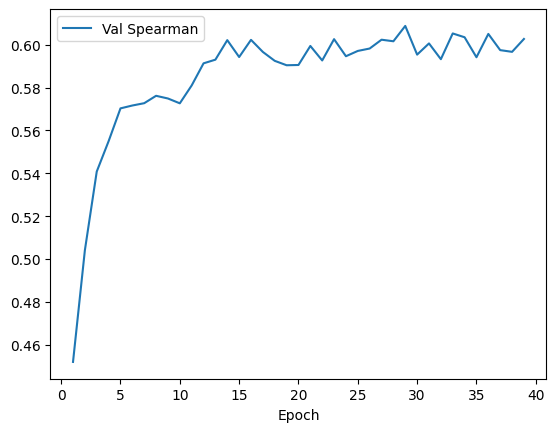

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


class CNN(nn.Module):
    def __init__(self, seq_length=41, num_channels=4, 
                 num_filters=32, kernel_sizes=[6, 9, 12], 
                 dropout=0.2):
        """
        1D CNN for RNA-Protein Binding Prediction
        
        Args:
            seq_length: Length of RNA sequence (41 for padded sequences)
            num_channels: Number of input channels (4 for one-hot encoded ACGU)
            num_filters: Number of convolutional filters per kernel size
            kernel_sizes: List of different kernel sizes (to detect different motif lengths)
            dropout: Dropout probability
        """
        super(CNN, self).__init__()
        
        # Multi-scale convolutional layers (like detecting motifs of different lengths)
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=num_channels, 
                         out_channels=num_filters,
                         kernel_size=k,
                         padding='same'),  # Ensures output length = input length
                nn.BatchNorm1d(num_filters),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2)
            )
            for k in kernel_sizes
        ])
        
        # Calculate the size after pooling
        pooled_length = seq_length // 2
        total_filters = num_filters * len(kernel_sizes)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(total_filters * pooled_length, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)  # Output: single binding affinity value
        )
    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length, num_channels)
               from utils.py: (batch, 41, 4)
        Returns:
            Binding affinity predictions of shape (batch_size,)
        """
        # Transpose to (batch_size, num_channels, seq_length) for Conv1d
        x = x.transpose(1, 2)  # (batch, 4, 41)
        
        # Apply each convolutional branch
        conv_outputs = [conv(x) for conv in self.conv_layers]
        
        # Concatenate along the channel dimension
        x = torch.cat(conv_outputs, dim=1)
        
        # Pass through fully connected layers
        x = self.fc(x)
        
        return x.squeeze(-1)  # Shape: (batch_size,)


# Training function
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch, mask_batch in loader:
        X_batch, y_batch, mask_batch = X_batch.to(device), y_batch.to(device), mask_batch.to(device)
        
        # Forward pass
        predictions = model(X_batch)
        loss = masked_mse_loss(predictions, y_batch, mask_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    all_masks = []
    
    with torch.no_grad():
        for X_batch, y_batch, mask_batch in loader:
            X_batch, y_batch, mask_batch = X_batch.to(device), y_batch.to(device), mask_batch.to(device)
            
            predictions = model(X_batch)
            loss = masked_mse_loss(predictions, y_batch, mask_batch)
            
            total_loss += loss.item()
            all_preds.append(predictions.cpu())
            all_targets.append(y_batch.cpu())
            all_masks.append(mask_batch.cpu())
    
    # Calculate metrics
    avg_loss = total_loss / len(loader)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    all_masks = torch.cat(all_masks)
    spearman = masked_spearman_correlation(all_preds, all_targets, all_masks)
    
    return avg_loss, spearman


# Main training loop
def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001, device='cuda', early_stop_patience = 10):
    print("Starting training!")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                            factor=0.9, patience=5)
    
    train_losses = []
    val_losses = []
    val_spearmans = []
    best_spearman = -1
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, device)
        
        # Validate
        val_loss, val_spearman = evaluate(model, val_loader, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Track metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_spearmans.append(val_spearman)
        
        # Save best model
        if val_spearman > best_spearman:
            best_spearman = val_spearman
            torch.save(model.state_dict(), 'best_cnn_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"    Early stopping at epoch {epoch+1}")
                break
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'  Train Loss: {train_loss:.4f}')
            print(f'  Val Loss: {val_loss:.4f}, Val Spearman: {val_spearman:.4f}')
    
    return train_losses, val_losses, val_spearmans


# Example usage
if __name__ == "__main__":
    # Load data
    train_dataset = load_rnacompete_data(protein_name='RBFOX1', split='train')
    val_dataset = load_rnacompete_data(protein_name='RBFOX1', split='val')
    test_dataset = load_rnacompete_data(protein_name='RBFOX1', split='test')
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Check input shape
    X_sample, y_sample, mask_sample = next(iter(train_loader))
    print(f"Input shape: {X_sample.shape}")  # Should be (batch_size, 41, 4)
    print(f"Target shape: {y_sample.shape}")  # Should be (batch_size, 1)
    print(f"Mask shape: {mask_sample.shape}")  # Should be (batch_size, 1)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN(
        seq_length=41,
        num_channels=4,
        num_filters=32,
        kernel_sizes=[6, 9, 12],  # Detect motifs of different lengths
        dropout=0.2
    )
    
    print(f"\nModel architecture:\n{model}")
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train
    train_losses, val_losses, val_spearmans = train_model(
        model, train_loader, val_loader,
        num_epochs=100,
        lr=0.005,
        device=device
    )
    
    # Plot results
    plt.figure(1)
    plot(list(range(1, len(train_losses) + 1)), 
            {'Train Loss': train_losses, 'Val Loss': val_losses})
    
    plt.figure(2)
    plot(list(range(1, len(val_spearmans) + 1)), 
            {'Val Spearman': val_spearmans})
    
    plt.show()
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_cnn_model.pt'))
    test_loss, test_spearman = evaluate(model, test_loader, device)
    print(f"\nFinal Test Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Spearman: {test_spearman:.4f}")

### CNN Hyperparameter Tunning

Loading data...
Found cached data for RBFOX1 (train). Loading from /home/catarinabarata/dl/data/RBFOX1_train_data.pt...
Found cached data for RBFOX1 (val). Loading from /home/catarinabarata/dl/data/RBFOX1_val_data.pt...
Found cached data for RBFOX1 (test). Loading from /home/catarinabarata/dl/data/RBFOX1_test_data.pt...
Using device: cuda

RUNNING GRID SEARCH
Total configurations to test: 64

[1/64] Testing config: {'num_filters': 32, 'kernel_sizes': [3, 6, 9], 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'weight_decay': 1e-05}


/home/catarinabarata/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


    Best Spearman: 0.5989

[2/64] Testing config: {'num_filters': 32, 'kernel_sizes': [3, 6, 9], 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'weight_decay': 0.0001}
    Early stopping at epoch 38
    Best Spearman: 0.5889

[3/64] Testing config: {'num_filters': 32, 'kernel_sizes': [3, 6, 9], 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'weight_decay': 1e-05}
    Best Spearman: 0.6018

[4/64] Testing config: {'num_filters': 32, 'kernel_sizes': [3, 6, 9], 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'weight_decay': 0.0001}
    Best Spearman: 0.5940

[5/64] Testing config: {'num_filters': 32, 'kernel_sizes': [3, 6, 9], 'dropout': 0.2, 'learning_rate': 0.005, 'batch_size': 64, 'weight_decay': 1e-05}
    Early stopping at epoch 11
    Best Spearman: 0.0036

[6/64] Testing config: {'num_filters': 32, 'kernel_sizes': [3, 6, 9], 'dropout': 0.2, 'learning_rate': 0.005, 'batch_size': 64, 'weight_decay': 0.0001}
    Early stopping at epoch 39
    Best Spe

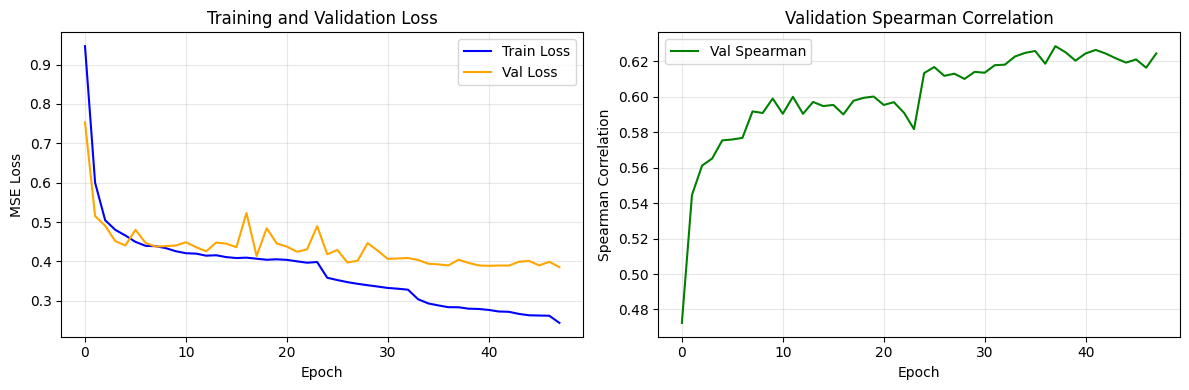

Saved to cnn_best_training_curves.png


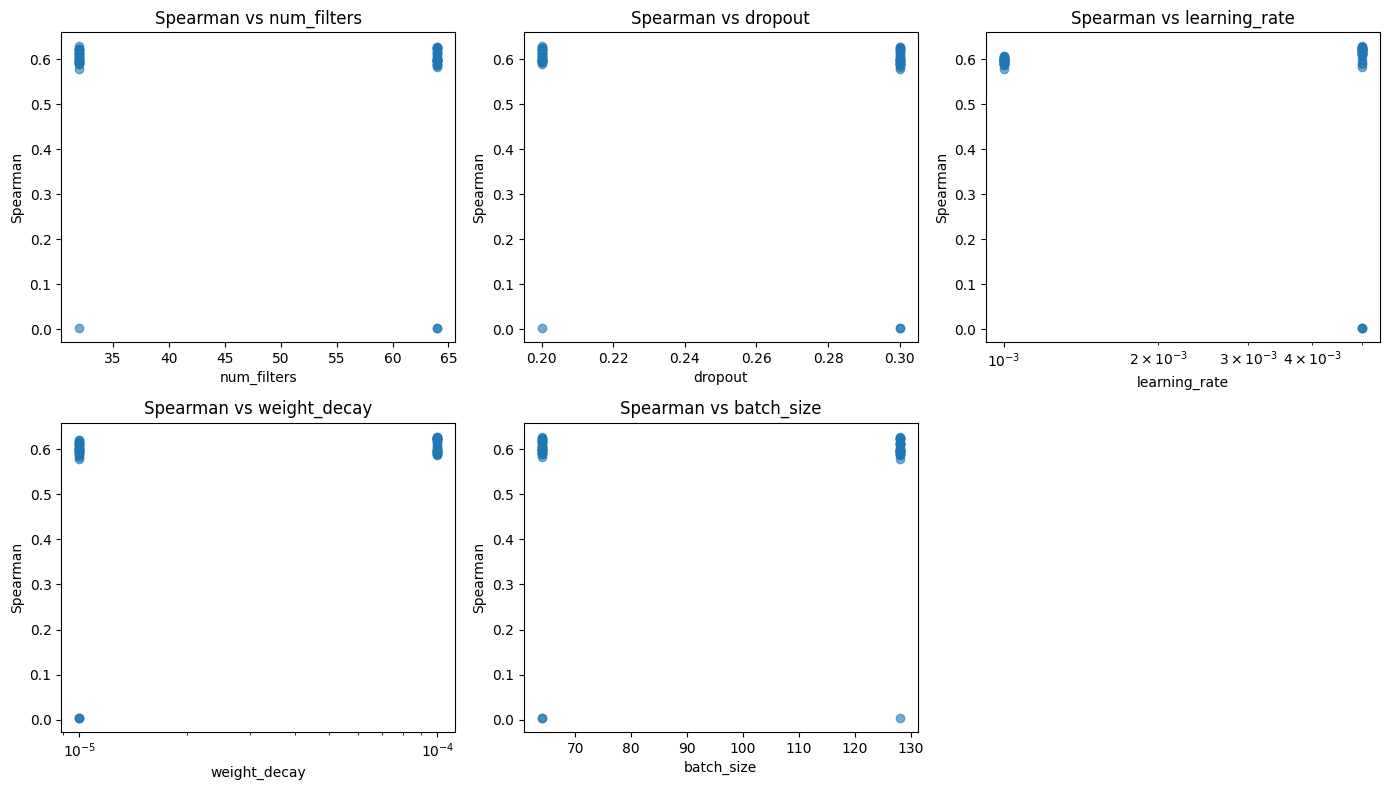


FINAL EVALUATION ON TEST SET
    Early stopping at epoch 44

Test Loss: 0.4050
Test Spearman: 0.6139


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import itertools
import json
from datetime import datetime
import matplotlib.pyplot as plt



# Your CNN class (same as before)
class CNN(nn.Module):
    def __init__(self, seq_length=41, num_channels=4, 
                 num_filters=32, kernel_sizes=[6, 9, 12], 
                 dropout=0.2):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=num_channels, 
                         out_channels=num_filters,
                         kernel_size=k,
                         padding='same'),
                nn.BatchNorm1d(num_filters),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2)
            )
            for k in kernel_sizes
        ])
        
        pooled_length = seq_length // 2
        total_filters = num_filters * len(kernel_sizes)
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(total_filters * pooled_length, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        x = x.transpose(1, 2)
        conv_outputs = [conv(x) for conv in self.conv_layers]
        x = torch.cat(conv_outputs, dim=1)
        x = self.fc(x)
        return x.squeeze(-1)


# ============================================================
# HYPERPARAMETER SEARCH CONFIGURATION
# ============================================================

HYPERPARAMETER_GRID = {
    # Architecture parameters
    'num_filters': [32, 64],
    'kernel_sizes': [
        [3, 6, 9],           # Smaller motifs
        [6, 9, 12],          # Medium motifs (RBFOX1 motif is 6bp)
    ],
    'dropout': [0.2, 0.3],
    
    # Training parameters
    'learning_rate': [1e-3, 5e-3],
    'batch_size': [64, 128],
    'weight_decay': [1e-5, 1e-4],
}



# ============================================================
# TRAINING FUNCTIONS
# ============================================================

def train_epoch(model, loader, optimizer, device, masked_mse_loss):
    model.train()
    total_loss = 0
    for X_batch, y_batch, mask_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)
        
        predictions = model(X_batch)
        loss = masked_mse_loss(predictions, y_batch, mask_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate(model, loader, device, masked_mse_loss, masked_spearman_correlation):
    model.eval()
    total_loss = 0
    all_preds, all_targets, all_masks = [], [], []
    
    with torch.no_grad():
        for X_batch, y_batch, mask_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            predictions = model(X_batch)
            loss = masked_mse_loss(predictions, y_batch, mask_batch)
            
            total_loss += loss.item()
            all_preds.append(predictions.cpu())
            all_targets.append(y_batch.cpu())
            all_masks.append(mask_batch.cpu())
    
    avg_loss = total_loss / len(loader)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    all_masks = torch.cat(all_masks)
    spearman = masked_spearman_correlation(all_preds, all_targets, all_masks)
    
    return avg_loss, spearman


def train_with_config(config, train_dataset, val_dataset, 
                      masked_mse_loss, masked_spearman_correlation,
                      num_epochs=50, device='cuda', early_stop_patience=10):
    """Train a model with a specific hyperparameter configuration."""
    
    # Create data loaders with specified batch size
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    # Initialize model
    model = CNN(
        seq_length=41,
        num_channels=4,
        num_filters=config['num_filters'],
        kernel_sizes=config['kernel_sizes'],
        dropout=config['dropout']
    ).to(device)
    
    # Optimizer with specified hyperparameters
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Training loop
    train_losses, val_losses, val_spearmans = [], [], []
    best_spearman = -1
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device, masked_mse_loss)
        val_loss, val_spearman = evaluate(model, val_loader, device, 
                                          masked_mse_loss, masked_spearman_correlation)
        
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_spearmans.append(val_spearman)
        
        # Early stopping based on Spearman (primary metric)
        if val_spearman > best_spearman:
            best_spearman = val_spearman
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"    Early stopping at epoch {epoch+1}")
                break
    
    return {
        'best_spearman': best_spearman,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_spearmans': val_spearmans,
        'best_state': best_state,
        'final_epoch': epoch + 1
    }


# ============================================================
# GRID SEARCH
# ============================================================

def grid_search(train_dataset, val_dataset, 
                masked_mse_loss, masked_spearman_correlation,
                param_grid=None, num_epochs=50, device='cuda'):
    """Perform grid search over hyperparameters."""
    
    if param_grid is None:
        param_grid = HYPERPARAMETER_GRID
    
    # Generate all combinations
    keys = list(param_grid.keys())
    combinations = list(itertools.product(*param_grid.values()))
    
    print(f"Total configurations to test: {len(combinations)}")
    
    results = []
    best_spearman = -1
    best_config = None
    
    for i, values in enumerate(combinations):
        config = dict(zip(keys, values))
        print(f"\n[{i+1}/{len(combinations)}] Testing config: {config}")
        
        result = train_with_config(
            config, train_dataset, val_dataset,
            masked_mse_loss, masked_spearman_correlation,
            num_epochs=num_epochs, device=device
        )
        
        results.append({
            'config': config,
            'best_spearman': result['best_spearman'],
            'final_epoch': result['final_epoch']
        })
        
        print(f"    Best Spearman: {result['best_spearman']:.4f}")
        
        if result['best_spearman'] > best_spearman:
            best_spearman = result['best_spearman']
            best_config = config
            best_result = result
    
    return {
        'all_results': results,
        'best_config': best_config,
        'best_spearman': best_spearman,
        'best_result': best_result
    }



# ============================================================
# PLOTTING FUNCTIONS
# ============================================================

def plot_training_curves(train_losses, val_losses, val_spearmans, save_path='training_curves.png'):
    """Plot training curves for the best model."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    axes[0].plot(train_losses, label='Train Loss', color='blue')
    axes[0].plot(val_losses, label='Val Loss', color='orange')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Spearman correlation
    axes[1].plot(val_spearmans, label='Val Spearman', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Spearman Correlation')
    axes[1].set_title('Validation Spearman Correlation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"Saved to {save_path}")


def plot_hyperparameter_importance(results, save_path='hyperparam_importance.png'):
    """Visualize which hyperparameters matter most."""
    import pandas as pd
    
    df = pd.DataFrame([{**r['config'], 'spearman': r['best_spearman']} for r in results])
    
    # Plot performance vs each hyperparameter
    numeric_params = ['num_filters', 'dropout', 'learning_rate', 'weight_decay', 'batch_size']
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    
    for i, param in enumerate(numeric_params):
        if param in df.columns:
            axes[i].scatter(df[param], df['spearman'], alpha=0.6)
            axes[i].set_xlabel(param)
            axes[i].set_ylabel('Spearman')
            axes[i].set_title(f'Spearman vs {param}')
            if param in ['learning_rate', 'weight_decay']:
                axes[i].set_xscale('log')
    
    axes[-1].axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()


if __name__ == "__main__":
    
    
    # Load data
    print("Loading data...")
    train_dataset = load_rnacompete_data(protein_name='RBFOX1', split='train')
    val_dataset = load_rnacompete_data(protein_name='RBFOX1', split='val')
    test_dataset = load_rnacompete_data(protein_name='RBFOX1', split='test')
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # ---- Option 1: Grid Search ----
    print("\n" + "="*60)
    print("RUNNING GRID SEARCH")
    print("="*60)
    
    search_results = grid_search(
        train_dataset, val_dataset,
        masked_mse_loss, masked_spearman_correlation,
        param_grid=HYPERPARAMETER_GRID,
        num_epochs=50,
        device=device
    )
    
    
    # Print results
    print("\n" + "="*60)
    print("SEARCH COMPLETE")
    print("="*60)
    print(f"\nBest configuration: {search_results['best_config']}")
    print(f"Best validation Spearman: {search_results['best_spearman']:.4f}")
    
    # Plot training curves for best model
    plot_training_curves(
        search_results['best_result']['train_losses'],
        search_results['best_result']['val_losses'],
        search_results['best_result']['val_spearmans'],
        save_path='cnn_best_training_curves.png'
    )
    
    # Plot hyperparameter importance
    plot_hyperparameter_importance(
        search_results['all_results'],
        save_path='cnn_hyperparam_importance.png'
    )
    
    # Save results to file
    results_to_save = {
        'best_config': search_results['best_config'],
        'best_spearman': search_results['best_spearman'],
        'all_results': [
            {'config': r['config'], 'spearman': r['best_spearman']} 
            for r in search_results['all_results']
        ]
    }
    
    with open('cnn_hyperparameter_search_results.json', 'w') as f:
        json.dump(results_to_save, f, indent=2, default=str)
    
    # ---- Final evaluation on test set ----
    print("\n" + "="*60)
    print("FINAL EVALUATION ON TEST SET")
    print("="*60)
    
    # Retrain best model and evaluate on test
    best_config = search_results['best_config']
    final_result = train_with_config(
        best_config, train_dataset, val_dataset,
        masked_mse_loss, masked_spearman_correlation,
        num_epochs=100,  # Train longer for final model
        device=device
    )
    
    # Load best model and evaluate on test
    model = CNN(
        num_filters=best_config['num_filters'],
        kernel_sizes=best_config['kernel_sizes'],
        dropout=best_config['dropout']
    ).to(device)
    model.load_state_dict(final_result['best_state'])
    
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    test_loss, test_spearman = evaluate(
        model, test_loader, device,
        masked_mse_loss, masked_spearman_correlation
    )
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Spearman: {test_spearman:.4f}")

### Using RNN

* Best configuration: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'bidirectional': True, 'rnn_type': 'LSTM', 'learning_rate': 0.001, 'batch_size': 64, 'weight_decay': 1e-05} Best validation Spearman: 0.6753


Using device: cuda

Loading data...
Found cached data for RBFOX1 (train). Loading from /home/catarinabarata/dl/data/RBFOX1_train_data.pt...
Found cached data for RBFOX1 (val). Loading from /home/catarinabarata/dl/data/RBFOX1_val_data.pt...
Found cached data for RBFOX1 (test). Loading from /home/catarinabarata/dl/data/RBFOX1_test_data.pt...

Input shape: torch.Size([64, 41, 4])
Target shape: torch.Size([64, 1])
Mask shape: torch.Size([64, 1])

Model architecture:
RNN(
  (rnn): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 145,537

TRAINING
Starting RNN training!
Device: cuda
Model parameters: 145,537


/home/catarinabarata/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5/100
  Train Loss: 0.4314
  Val Loss: 0.3948, Val Spearman: 0.6077
  Best Spearman: 0.6077
Epoch 10/100
  Train Loss: 0.3747
  Val Loss: 0.3624, Val Spearman: 0.6405
  Best Spearman: 0.6405
Epoch 15/100
  Train Loss: 0.3378
  Val Loss: 0.3669, Val Spearman: 0.6456
  Best Spearman: 0.6547
Epoch 20/100
  Train Loss: 0.3164
  Val Loss: 0.3446, Val Spearman: 0.6585
  Best Spearman: 0.6592
Epoch 25/100
  Train Loss: 0.2948
  Val Loss: 0.3308, Val Spearman: 0.6659
  Best Spearman: 0.6689
Epoch 30/100
  Train Loss: 0.2766
  Val Loss: 0.3370, Val Spearman: 0.6710
  Best Spearman: 0.6710
Epoch 35/100
  Train Loss: 0.2595
  Val Loss: 0.3332, Val Spearman: 0.6689
  Best Spearman: 0.6721
Epoch 40/100
  Train Loss: 0.2500
  Val Loss: 0.3347, Val Spearman: 0.6729
  Best Spearman: 0.6748
Epoch 45/100
  Train Loss: 0.2235
  Val Loss: 0.3207, Val Spearman: 0.6750
  Best Spearman: 0.6750
Epoch 50/100
  Train Loss: 0.2118
  Val Loss: 0.3187, Val Spearman: 0.6743
  Best Spearman: 0.6753
Epoch 55/10

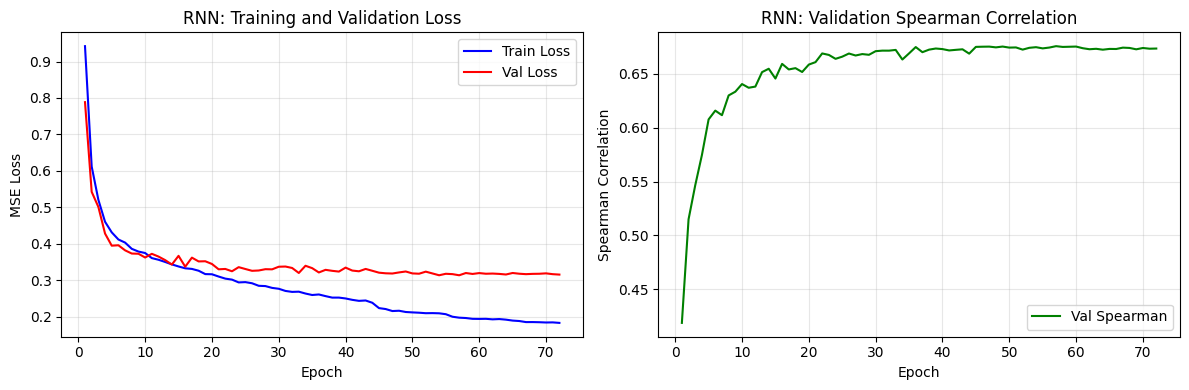


FINAL TEST EVALUATION

Test Loss: 0.3290
Test Spearman: 0.6727

SUMMARY
Best Validation Spearman: 0.6756
Final Test Spearman: 0.6727


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class RNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, 
                 dropout=0.3, bidirectional=True, rnn_type='LSTM'):
        """
        RNN for RNA-Protein Binding Prediction
        
        Args:
            input_size: Number of input features (4 for one-hot encoded ACGU)
            hidden_size: Number of hidden units in RNN
            num_layers: Number of stacked RNN layers
            dropout: Dropout probability
            bidirectional: Whether to use bidirectional RNN
            rnn_type: 'LSTM', 'GRU', or 'RNN'
        """
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # Select RNN type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        else:
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                nonlinearity='tanh'
            )
        
        # Fully connected layers
        fc_input_size = hidden_size * self.num_directions
        
        self.fc = nn.Sequential(
            nn.Linear(fc_input_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        

    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size)
               from utils.py: (batch, 41, 4)
        Returns:
            Binding affinity predictions of shape (batch_size,)
        """
        # x shape: (batch, seq_len, 4)
        
        # RNN forward pass
        # output shape: (batch, seq_len, hidden_size * num_directions)
        # hidden shape: (num_layers * num_directions, batch, hidden_size)
        rnn_out, hidden = self.rnn(x)
        
        # Use last hidden state
        if isinstance(hidden, tuple):  # LSTM returns (hidden, cell)
            hidden = hidden[0]
        
        # Concatenate forward and backward final hidden states
        if self.bidirectional:
            # hidden shape: (num_layers * 2, batch, hidden_size)
            # Take last layer's forward and backward
            forward_hidden = hidden[-2, :, :]  # (batch, hidden_size)
            backward_hidden = hidden[-1, :, :]  # (batch, hidden_size)
            context = torch.cat([forward_hidden, backward_hidden], dim=1)
        else:
            context = hidden[-1, :, :]
        
        # Pass through fully connected layers
        out = self.fc(context)
        
        return out.squeeze(-1)


def train_epoch(model, loader, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for X_batch, y_batch, mask_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)
        
        predictions = model(X_batch)
        loss = masked_mse_loss(predictions, y_batch, mask_batch)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (important for RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)


def evaluate(model, loader, device):
    """Evaluate model on a dataset."""
    model.eval()
    total_loss = 0
    all_preds, all_targets, all_masks = [], [], []
    
    with torch.no_grad():
        for X_batch, y_batch, mask_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            predictions = model(X_batch)
            loss = masked_mse_loss(predictions, y_batch, mask_batch)
            
            total_loss += loss.item()
            all_preds.append(predictions.cpu())
            all_targets.append(y_batch.cpu())
            all_masks.append(mask_batch.cpu())
    
    avg_loss = total_loss / len(loader)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    all_masks = torch.cat(all_masks)
    spearman = masked_spearman_correlation(all_preds, all_targets, all_masks)
    
    return avg_loss, spearman


def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001, device='cuda'):
    """Full training loop with early stopping."""
    print("Starting RNN training!")
    print(f"Device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=7, verbose=True
    )
    
    train_losses, val_losses, val_spearmans = [], [], []
    best_spearman = -1
    patience_counter = 0
    early_stop_patience = 15
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, device)
        
        # Validate
        val_loss, val_spearman = evaluate(model, val_loader, device)
        
        # Learning rate scheduling based on Spearman (primary metric)
        scheduler.step(val_spearman)
        
        # Track metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_spearmans.append(val_spearman)
        
        # Save best model
        if val_spearman > best_spearman:
            best_spearman = val_spearman
            torch.save(model.state_dict(), 'best_rnn_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'  Train Loss: {train_loss:.4f}')
            print(f'  Val Loss: {val_loss:.4f}, Val Spearman: {val_spearman:.4f}')
            print(f'  Best Spearman: {best_spearman:.4f}')
        
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    return train_losses, val_losses, val_spearmans


def plot_results(train_losses, val_losses, val_spearmans):
    """Plot training curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Loss plot
    axes[0].plot(epochs, train_losses, 'b-', label='Train Loss')
    axes[0].plot(epochs, val_losses, 'r-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].set_title('RNN: Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Spearman plot
    axes[1].plot(epochs, val_spearmans, 'g-', label='Val Spearman')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Spearman Correlation')
    axes[1].set_title('RNN: Validation Spearman Correlation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    print("\nLoading data...")
    train_dataset = load_rnacompete_data(protein_name='RBFOX1', split='train')
    val_dataset = load_rnacompete_data(protein_name='RBFOX1', split='val')
    test_dataset = load_rnacompete_data(protein_name='RBFOX1', split='test')
    
    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Check input shape
    X_sample, y_sample, mask_sample = next(iter(train_loader))
    print(f"\nInput shape: {X_sample.shape}")   # (batch_size, 41, 4)
    print(f"Target shape: {y_sample.shape}")    # (batch_size,) or (batch_size, 1)
    print(f"Mask shape: {mask_sample.shape}")
    
    # Initialize model
    model = RNN(
        input_size=4,           # One-hot encoded ACGU
        hidden_size=64,        # Hidden units
        num_layers=2,           # Stacked RNN layers
        dropout=0.2,            # Dropout rate
        bidirectional=True,     # Process sequence in both directions
        rnn_type='LSTM'         # Options: 'LSTM', 'GRU', 'RNN'
    )
    
    print(f"\nModel architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train model
    print("\n" + "="*60)
    print("TRAINING")
    print("="*60)
    
    train_losses, val_losses, val_spearmans = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=100,
        lr=0.001,
        device=device
    )
    
    # Plot training curves
    print("\n" + "="*60)
    print("PLOTTING RESULTS")
    print("="*60)
    plot_results(train_losses, val_losses, val_spearmans)
    
    # Load best model and evaluate on test set
    print("\n" + "="*60)
    print("FINAL TEST EVALUATION")
    print("="*60)
    
    model.load_state_dict(torch.load('best_rnn_model.pt'))
    test_loss, test_spearman = evaluate(model, test_loader, device)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Spearman: {test_spearman:.4f}")
    
    # Summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"Best Validation Spearman: {max(val_spearmans):.4f}")
    print(f"Final Test Spearman: {test_spearman:.4f}")

### RNN hyperparameter tunning

Using device: cuda

Loading data...
Found cached data for RBFOX1 (train). Loading from /home/catarinabarata/dl/data/RBFOX1_train_data.pt...
Found cached data for RBFOX1 (val). Loading from /home/catarinabarata/dl/data/RBFOX1_val_data.pt...
Found cached data for RBFOX1 (test). Loading from /home/catarinabarata/dl/data/RBFOX1_test_data.pt...

RUNNING GRID SEARCH
Total configurations to test: 16

[1/16] Testing: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'bidirectional': True, 'rnn_type': 'LSTM', 'learning_rate': 0.001, 'batch_size': 64, 'weight_decay': 1e-05}
    Best Spearman: 0.6698

[2/16] Testing: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'bidirectional': True, 'rnn_type': 'LSTM', 'learning_rate': 0.001, 'batch_size': 64, 'weight_decay': 0.0001}
    Best Spearman: 0.6551

[3/16] Testing: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'bidirectional': True, 'rnn_type': 'LSTM', 'learning_rate': 0.0005, 'batch_size': 64, 'weight_decay': 1e-05}
    Best Spearma

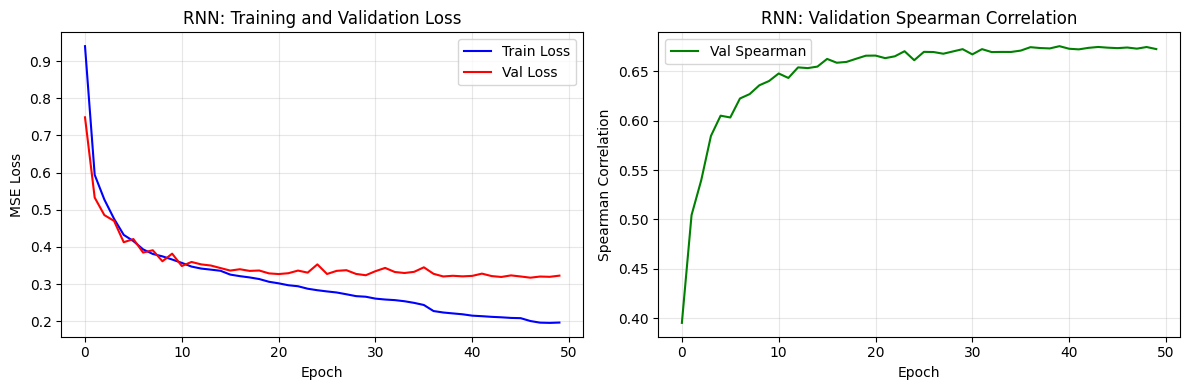

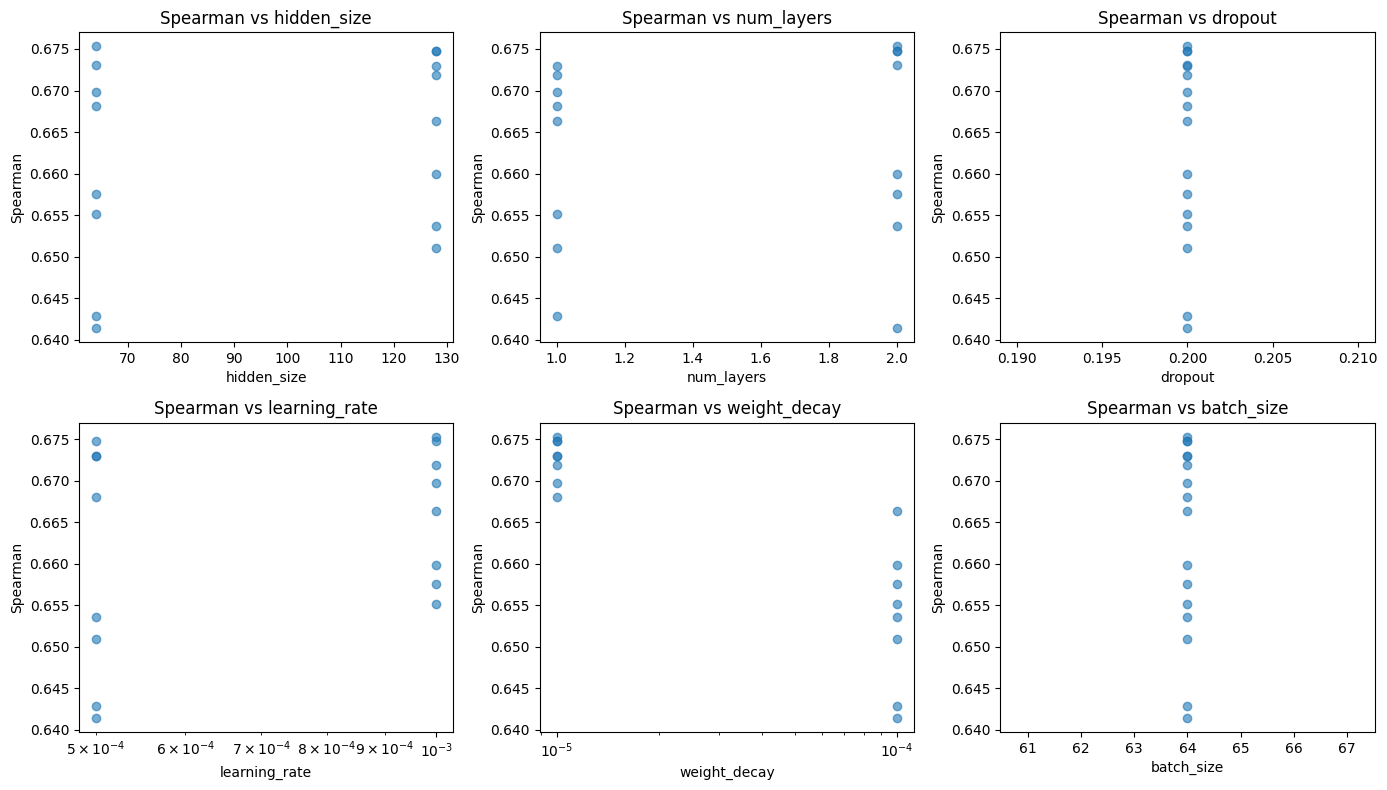

TypeError: Object of type Tensor is not JSON serializable

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import itertools
import json
import random
import matplotlib.pyplot as plt


class RNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, 
                 dropout=0.3, bidirectional=True, rnn_type='LSTM'):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        else:
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                nonlinearity='tanh'
            )
        
        fc_input_size = hidden_size * self.num_directions
        
        self.fc = nn.Sequential(
            nn.Linear(fc_input_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        rnn_out, hidden = self.rnn(x)
        
        if isinstance(hidden, tuple):
            hidden = hidden[0]
        
        if self.bidirectional:
            forward_hidden = hidden[-2, :, :]
            backward_hidden = hidden[-1, :, :]
            context = torch.cat([forward_hidden, backward_hidden], dim=1)
        else:
            context = hidden[-1, :, :]
        
        out = self.fc(context)
        return out.squeeze(-1)


# ============================================================
# HYPERPARAMETER SEARCH CONFIGURATION
# ============================================================


# Smaller grid for faster search
HYPERPARAMETER_GRID_SMALL = {
    'hidden_size': [64, 128],
    'num_layers': [1, 2],
    'dropout': [0.2],
    'bidirectional': [True],
    'rnn_type': ['LSTM'],
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [64],
    'weight_decay': [1e-5, 1e-4],
}


# ============================================================
# TRAINING FUNCTIONS
# ============================================================

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch, mask_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask_batch = mask_batch.to(device)
        
        predictions = model(X_batch)
        loss = masked_mse_loss(predictions, y_batch, mask_batch)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets, all_masks = [], [], []
    
    with torch.no_grad():
        for X_batch, y_batch, mask_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            predictions = model(X_batch)
            loss = masked_mse_loss(predictions, y_batch, mask_batch)
            
            total_loss += loss.item()
            all_preds.append(predictions.cpu())
            all_targets.append(y_batch.cpu())
            all_masks.append(mask_batch.cpu())
    
    avg_loss = total_loss / len(loader)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    all_masks = torch.cat(all_masks)
    spearman = masked_spearman_correlation(all_preds, all_targets, all_masks)
    
    return avg_loss, spearman


def train_with_config(config, train_dataset, val_dataset,
                      num_epochs=50, device='cuda', early_stop_patience=10):
    """Train a model with a specific hyperparameter configuration."""
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    model = RNN(
        input_size=4,
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional'],
        rnn_type=config['rnn_type']
    ).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    train_losses, val_losses, val_spearmans = [], [], []
    best_spearman = -1
    best_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_spearman = evaluate(model, val_loader, device)
        
        scheduler.step(val_spearman)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_spearmans.append(val_spearman)
        
        if val_spearman > best_spearman:
            best_spearman = val_spearman
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"    Early stopping at epoch {epoch+1}")
                break
    
    return {
        'best_spearman': best_spearman,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_spearmans': val_spearmans,
        'best_state': best_state,
        'final_epoch': epoch + 1
    }


# ============================================================
# GRID SEARCH
# ============================================================

def grid_search(train_dataset, val_dataset, param_grid=None,
                num_epochs=50, device='cuda'):
    """Perform grid search over hyperparameters."""
    
    if param_grid is None:
        param_grid = HYPERPARAMETER_GRID_SMALL
    
    keys = list(param_grid.keys())
    combinations = list(itertools.product(*param_grid.values()))
    
    print(f"Total configurations to test: {len(combinations)}")
    
    results = []
    best_spearman = -1
    best_config = None
    best_result = None
    
    for i, values in enumerate(combinations):
        config = dict(zip(keys, values))
        print(f"\n[{i+1}/{len(combinations)}] Testing: {config}")
        
        result = train_with_config(
            config, train_dataset, val_dataset,
            num_epochs=num_epochs, device=device
        )
        
        results.append({
            'config': config,
            'best_spearman': result['best_spearman'],
            'final_epoch': result['final_epoch']
        })
        
        print(f"    Best Spearman: {result['best_spearman']:.4f}")
        
        if result['best_spearman'] > best_spearman:
            best_spearman = result['best_spearman']
            best_config = config
            best_result = result
    
    return {
        'all_results': results,
        'best_config': best_config,
        'best_spearman': best_spearman,
        'best_result': best_result
    }


# ============================================================
# PLOTTING FUNCTIONS
# ============================================================

def plot_training_curves(train_losses, val_losses, val_spearmans):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(train_losses, 'b-', label='Train Loss')
    axes[0].plot(val_losses, 'r-', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].set_title('RNN: Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(val_spearmans, 'g-', label='Val Spearman')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Spearman Correlation')
    axes[1].set_title('RNN: Validation Spearman Correlation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
  


def plot_hyperparameter_importance(results):
    import pandas as pd
    
    df = pd.DataFrame([{**r['config'], 'spearman': r['best_spearman']} for r in results])
    
    numeric_params = ['hidden_size', 'num_layers', 'dropout', 'learning_rate', 'weight_decay', 'batch_size']
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    
    for i, param in enumerate(numeric_params):
        if param in df.columns:
            axes[i].scatter(df[param], df['spearman'], alpha=0.6)
            axes[i].set_xlabel(param)
            axes[i].set_ylabel('Spearman')
            axes[i].set_title(f'Spearman vs {param}')
            if param in ['learning_rate', 'weight_decay']:
                axes[i].set_xscale('log')
    
    plt.tight_layout()
    plt.show()


# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    print("\nLoading data...")
    train_dataset = load_rnacompete_data(protein_name='RBFOX1', split='train')
    val_dataset = load_rnacompete_data(protein_name='RBFOX1', split='val')
    test_dataset = load_rnacompete_data(protein_name='RBFOX1', split='test')
    
    # ---- Run Grid Search ----
    print("\n" + "="*60)
    print("RUNNING GRID SEARCH")
    print("="*60)
    
    search_results = grid_search(
        train_dataset, val_dataset,
        param_grid=HYPERPARAMETER_GRID_SMALL,
        num_epochs=50,
        device=device
    )
    
    
    # Print results
    print("\n" + "="*60)
    print("SEARCH COMPLETE")
    print("="*60)
    print(f"\nBest configuration: {search_results['best_config']}")
    print(f"Best validation Spearman: {search_results['best_spearman']:.4f}")
    
    # Plot training curves for best model
    plot_training_curves(
        search_results['best_result']['train_losses'],
        search_results['best_result']['val_losses'],
        search_results['best_result']['val_spearmans'],
    )
    
    # Plot hyperparameter importance
    plot_hyperparameter_importance(
        search_results['all_results']
    )
    
    
   # Save results (convert tensors to floats for JSON serialization)
    def to_serializable(val):
        if isinstance(val, torch.Tensor):
            return val.item()
        elif isinstance(val, (list, tuple)):
            return [to_serializable(v) for v in val]
        return val
    
    results_to_save = {
        'best_config': {k: str(v) for k, v in search_results['best_config'].items()},
        'best_spearman': to_serializable(search_results['best_spearman']),
        'all_results': [
            {'config': {k: str(v) for k, v in r['config'].items()}, 
             'spearman': to_serializable(r['best_spearman'])}
            for r in search_results['all_results']
        ]
    }
    
    with open('rnn_hyperparameter_search_results.json', 'w') as f:
        json.dump(results_to_save, f, indent=2)
    print("\nSaved results to rnn_hyperparameter_search_results.json")
    
    # ---- Final Test Evaluation ----
    print("\n" + "="*60)
    print("FINAL TEST EVALUATION")
    print("="*60)
    
    best_config = search_results['best_config']
    
    # Retrain with best config for longer
    final_result = train_with_config(
        best_config, train_dataset, val_dataset,
        num_epochs=100,
        device=device
    )
    
    # Load best model
    model = RNN(
        input_size=4,
        hidden_size=best_config['hidden_size'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout'],
        bidirectional=best_config['bidirectional'],
        rnn_type=best_config['rnn_type']
    ).to(device)
    model.load_state_dict(final_result['best_state'])
    
    # Evaluate on test set
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    test_loss, test_spearman = evaluate(model, test_loader, device)
    
    print(f"\nBest Config: {best_config}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Spearman: {test_spearman:.4f}")
    
    # Save best model
    torch.save(model.state_dict(), 'best_rnn_model_tuned.pt')
    print("\nSaved best model to best_rnn_model_tuned.pt")